In [26]:
# Raster processing script 
# Author: Ben Kraas
# Coding assistant: Github Copilot

# imports
from datetime import datetime
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import re

In [27]:
# Get script directory
script_dir = Path("")

# load all five raster files (NDVI)
raster_folder = script_dir / "data" / "source" / "ndvi-tif"

# iterate over all files in the folder, load the rasters and store the data and metadata in a dictionary
rasters = {}
for raster_file in raster_folder.glob("*.tif"):
    # open the raster file
    with rasterio.open(raster_file) as src:
        # read the data
        data = src.read(1)
        # print the metadata
        print(f"File loaded: {raster_file.name}")
        print(f"Data type: {data.dtype}")
        print(f"Shape: {data.shape}")
        print(f"CRS: {src.crs}")
        
        # get year from filename (YYYY) with regex
        year_match = re.search(r"_(\d{4})_", raster_file.name)
        if year_match:
            year = int(year_match.group(1))
        else:
            raise ValueError(f"Year not found in filename: {raster_file.name}")
        print(f"Year: {year}")
        print()

        # add the data to the dictionary
        rasters[year] = {
            "data": data,
            "transform": src.transform,
            "crs": src.crs,
            "bounds": src.bounds,
            "name": raster_file.name,
            "year": year
        }

print(f"Success, loaded {len(rasters)} rasters from {min(rasters.keys())} (incl.) to {max(rasters.keys())} (incl.)")

File loaded: NDVI_Mean_2022_06.tif
Data type: float32
Shape: (9045, 16128)
CRS: EPSG:4326
Year: 2022

File loaded: NDVI_Mean_2021_06.tif
Data type: float32
Shape: (9045, 16128)
CRS: EPSG:4326
Year: 2021

File loaded: NDVI_Mean_2024_06.tif
Data type: float32
Shape: (9045, 16128)
CRS: EPSG:4326
Year: 2024

File loaded: NDVI_Mean_2023_06.tif
Data type: float32
Shape: (9045, 16128)
CRS: EPSG:4326
Year: 2023

File loaded: NDVI_Mean_2020_06.tif
Data type: float32
Shape: (9045, 16128)
CRS: EPSG:4326
Year: 2020

Success, loaded 5 rasters from 2020 (incl.) to 2024 (incl.)


In [ ]:
# Calculate NDVI difference on pixel-level
ndvi_diff = []  # this should yield a total of four rasters
raster_years = sorted(rasters.keys())  # Sort years to ensure correct order
for i in range(len(raster_years) - 1):
    current_data = rasters[raster_years[i]]["data"]
    next_data = rasters[raster_years[i + 1]]["data"]
    ndvi_diff.append(next_data - current_data)
print(f"Success: Number of NDVI differences: {len(ndvi_diff)}, Shapes: {[r.shape for r in ndvi_diff]}")

# Flatten the list of NDVI differences for boxplot
ndvi_diff_flat = [arr.ravel() for arr in ndvi_diff]

# Create a subsample of random values for better performance in the boxplots (48M values (many NaN) x4 is a bit much)
# Sample 10,000 random values from each NDVI difference array
ndvi_diff_sampled = []
for arr in ndvi_diff:
    flat = arr.ravel()
    flat = flat[~np.isnan(flat)]  # Remove NaNs

    if flat.size > 10000:
        sample = np.random.choice(flat, 10000, replace=False)
    else:
        sample = flat

    ndvi_diff_sampled.append(sample)

Success: Number of NDVI differences: 4, Shapes: [(9045, 16128), (9045, 16128), (9045, 16128), (9045, 16128)]


In [29]:
# Set up a statistical summary dictionary with the adjusted structure
stat_summary = {
    "actual": {
        "mean": {year: np.nanmean(rasters[year]["data"]) for year in raster_years},
        "min":  {year: np.nanmin(rasters[year]["data"]) for year in raster_years},
        "max":  {year: np.nanmax(rasters[year]["data"]) for year in raster_years},
        "std":  {year: np.nanstd(rasters[year]["data"]) for year in raster_years},
    },
    "change": {
        "mean": {year: np.nanmean(ndvi_diff[i]) for i, year in enumerate(raster_years[:-1])},
        "min":  {year: np.nanmin(ndvi_diff[i]) for i, year in enumerate(raster_years[:-1])},
        "max":  {year: np.nanmax(ndvi_diff[i]) for i, year in enumerate(raster_years[:-1])},
        "std":  {year: np.nanstd(ndvi_diff[i]) for i, year in enumerate(raster_years[:-1])},
    }
}
print(f"Success: NDVI statistics calculated for {len(stat_summary['actual']['mean'])} years and {len(stat_summary['change']['mean'])} differences")

Success: NDVI statistics calculated for 5 years and 4 differences


In [30]:
# Print statistics as indented JSON for better readability

# Serialize all float32 values to JSON-compatible floats
for category in stat_summary:
    for stat_type in stat_summary[category]:
        for year in stat_summary[category][stat_type]:
            stat_summary[category][stat_type][year] = float(stat_summary[category][stat_type][year])

# Print the statistics
print(json.dumps(stat_summary, indent=4))

{
    "actual": {
        "mean": {
            "2020": 0.532214879989624,
            "2021": 0.6563761234283447,
            "2022": 0.5918649435043335,
            "2023": 0.651524007320404,
            "2024": 0.43357083201408386
        },
        "min": {
            "2020": -0.670314371585846,
            "2021": -0.6239209771156311,
            "2022": -0.5810140371322632,
            "2023": -0.6572139263153076,
            "2024": -0.8230562806129456
        },
        "max": {
            "2020": 0.952194094657898,
            "2021": 0.962430477142334,
            "2022": 0.9446407556533813,
            "2023": 0.94045490026474,
            "2024": 0.963087260723114
        },
        "std": {
            "2020": 0.1880708783864975,
            "2021": 0.20265918970108032,
            "2022": 0.18205659091472626,
            "2023": 0.19684958457946777,
            "2024": 0.18286442756652832
        }
    },
    "change": {
        "mean": {
            "2020": 0.124159932

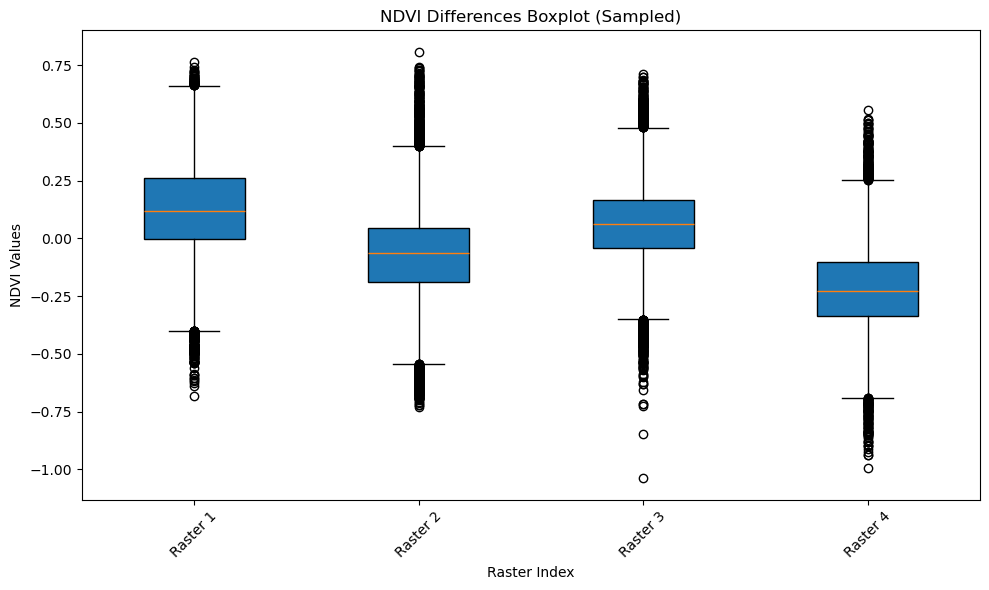

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(ndvi_diff_sampled, vert=True, patch_artist=True)

ax.set_title("NDVI Differences Boxplot (Sampled)")
ax.set_xlabel("Raster Index")
ax.set_ylabel("NDVI Values")
ax.set_xticks(range(1, len(ndvi_diff_sampled) + 1))
ax.set_xticklabels([f"Raster {i+1}" for i in range(len(ndvi_diff_sampled))], rotation=45)

plt.tight_layout()
plt.show()

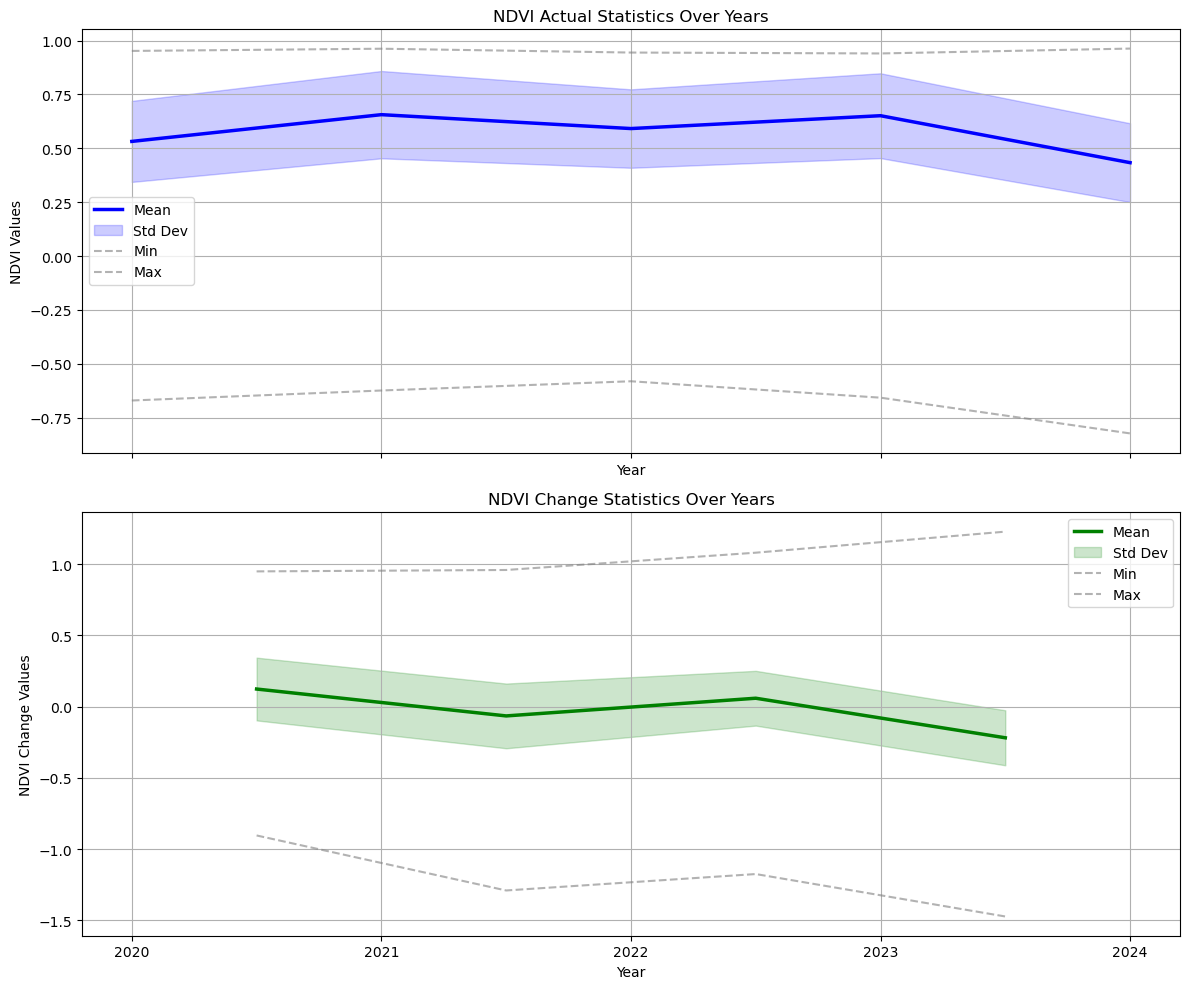

In [36]:
# Conceptualization of the Plot layout: Ben Kraas
# Code written by Github Copilot (thank you!)

# Plotting the statistics
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot "actual" statistics
for stat_type in ["mean", "std", "min", "max"]:
    if stat_type == "mean":
        axes[0].plot(raster_years, [stat_summary["actual"][stat_type][year] for year in raster_years], 
                     label="Mean", color="blue", linewidth=2.5)
    elif stat_type == "std":
        mean_values = [stat_summary["actual"]["mean"][year] for year in raster_years]
        std_values = [stat_summary["actual"]["std"][year] for year in raster_years]
        axes[0].fill_between(raster_years, 
                             [m - s for m, s in zip(mean_values, std_values)], 
                             [m + s for m, s in zip(mean_values, std_values)], 
                             color="blue", alpha=0.2, label="Std Dev")
    else:
        axes[0].plot(raster_years, [stat_summary["actual"][stat_type][year] for year in raster_years], 
                     label=stat_type.capitalize(), color="gray", linestyle="--", alpha=0.6)

axes[0].set_title("NDVI Actual Statistics Over Years")
axes[0].set_ylabel("NDVI Values")
axes[0].set_xlabel("Year")
axes[0].set_xticks(raster_years)
axes[0].set_xticklabels(raster_years)
axes[0].legend()
axes[0].grid(True)

# Plot "change" statistics
for stat_type in ["mean", "std", "min", "max"]:
    if stat_type == "mean":
        axes[1].plot([year + 0.5 for year in raster_years[:-1]], 
                     [stat_summary["change"][stat_type][year] for year in raster_years[:-1]], 
                     label="Mean", color="green", linewidth=2.5)
    elif stat_type == "std":
        mean_values = [stat_summary["change"]["mean"][year] for year in raster_years[:-1]]
        std_values = [stat_summary["change"]["std"][year] for year in raster_years[:-1]]
        axes[1].fill_between([year + 0.5 for year in raster_years[:-1]], 
                             [m - s for m, s in zip(mean_values, std_values)], 
                             [m + s for m, s in zip(mean_values, std_values)], 
                             color="green", alpha=0.2, label="Std Dev")
    else:
        axes[1].plot([year + 0.5 for year in raster_years[:-1]], 
                     [stat_summary["change"][stat_type][year] for year in raster_years[:-1]], 
                     label=stat_type.capitalize(), color="gray", linestyle="--", alpha=0.6)

axes[1].set_title("NDVI Change Statistics Over Years")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("NDVI Change Values")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()